# Lab 2. Numerical differentiation

High Performance Computing, Innopolis University, Spring 2018

In [1]:
# Import common modules and set up cute plots
import math
import numpy as np
from typing import List, Iterable
from IPython.core.display import HTML, display

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)

## Optimal step size

Let's recall some theory.

If we compute f' as (f(x+h)-f(x))/h, then we have two sources of error:
- Round-off error: `2**(2-t) * abs(f(x))/h`
- Approximation error (also called truncation error): `M2 * h/2`

Here, t is the length of the mantissa (in bits), M2 is the maximum of the second derivative of f, and h is the differentiation step.

Let's check this theory with the snippet below:

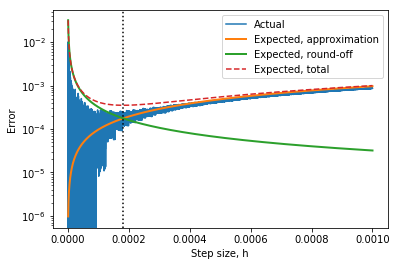

In [2]:
f = lambda x: np.sin(x)**2  # The function itself
df = lambda x: np.sin(2*x)  # It's first (analytical) derivative
d2f = lambda x: 2*np.cos(x)  # Second (analytical) derivative
dtype, m_len = np.float32, 23  # Floating-point type used, and corresponding mantissa length in bits

hs = np.linspace(1e-6,1e-3,10000, dtype=dtype)  # Different step sizes to test
x = dtype(np.pi/12)  # Point at which we compute the derivative

# Round-off error
err_r = 2**(2-m_len) * np.abs(f(x)) / hs
# Approximation error
err_a = np.abs(d2f(x)) * hs / 2  # We assume that change in f'' is insignificant on [x, x+h]
# Actual error
err_e = (f(x+hs)-f(x))/hs - df(x)

h_opt = np.sqrt(2**(3-m_len) * np.abs(f(x) / d2f(x)))

plt.plot(hs, err_e, label='Actual')
plt.plot(hs, err_a, label='Expected, approximation', lw=2)
plt.plot(hs, err_r, label='Expected, round-off', lw=2)
plt.plot(hs, err_a+err_r, '--', label='Expected, total')
plt.axvline(h_opt, ls=':', color='k')
plt.legend()
plt.xlabel('Step size, h')
plt.ylabel('Error')
plt.semilogy()
plt.show()

We see that total expected error (red, dashed) pretty accurately estimates the actual error (blue). We can also see which component — approximation (orange) or round-off (green) — contributes mainly for each step size. Please, keep in mind that Y-axis is logarithmic.

The black dashed vertical line indicate computed optimal value of step size.

If you experiment with different points, you can see that the estimation is not always working very good.
For example, the error is overestimated significantly at x=π/3. But for most points, the actual and expected errors are pretty close.

We can also see that actual error varies wildly for small step sizes when it is determined by round-off error. This is to be expected: the round-off error is very stochastic in nature, and errors on two consecutive steps can either cancel or amplify each other. When doing the theoretical analysis, we always assume worst case.

## Symbolic and automatic differentiation

Above we dealt with numerical differentiation, _i.e._, using finite differences methods to approximately find 
the value of the derivative.

But computers can do more. Symbolic differentiation allows one to find the value of the derivative by automatically doing the same operations you did in Calculus course, like looking up the derivatives of fundamental functions, applying chain rule etc.

_Note_: [Symbolic](https://en.wikipedia.org/wiki/Computer_algebra) and [automatic](https://en.wikipedia.org/wiki/Automatic_differentiation) differentiations are [fundamentally different](https://alexey.radul.name/ideas/2013/introduction-to-automatic-differentiation/#ad-is-not-symbolic-differentiation), but I don't distinguish them here. Tensorflow, used below, employs automatic differentiation.

This Tensorflow example that calculates the derivative of `sin(x)**2` for x=π/17.
We also compute the value using manually-derived derivative, and using double-precision numerical differentiation.

In [3]:
x0 = np.pi / 17  # The point

print('Analytical: {:.17f}'.format(np.sin(2*x0)))

import tensorflow as tf
tf.reset_default_graph()
x = tf.placeholder(tf.float64)
y = tf.square(tf.sin(x))
dy = tf.gradients([y], [x])[0]
with tf.Session() as sess:
    print('Tensorflow: {:.17f}'.format(sess.run(dy, feed_dict={x: [x0]})[0]))

# Finding the optimal step for numerical differentiation
h_opt = np.sqrt(2**(3-52) * np.abs(np.sin(x0)**2 / (2*np.cos(x0)))) 
print('Numerical : {:.17f}'.format((np.sin(x0+h_opt)**2 - np.sin(x0)**2)/h_opt))

Analytical: 0.36124166618715292
Tensorflow: 0.36124166618715298
Numerical : 0.36124166985988576
